In [39]:
# More advanced feature engineering with aggregations
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Read data
df = pd.read_csv('customer_churn.csv')

# Basic cleaning
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 1. Customer Value Features
df['MonthlyARPU'] = df['TotalCharges'] / df['Tenure']  # Average Revenue Per User
df['RevenuePerService'] = df['MonthlyCharges'] / (df['PhoneService'].map({'Yes': 1, 'No': 0}) + 
                                                 df['InternetService'].map({'Fiber optic': 1, 'DSL': 1, 'No': 0}))

df['RevenuePerService'] = df['RevenuePerService'].replace([np.inf, -np.inf], 0)


# 2. Service Usage Intensity
df['ServiceCount'] = (df['PhoneService'].map({'Yes': 1, 'No': 0}) + 
                     df['InternetService'].map({'Fiber optic': 1, 'DSL': 1, 'No': 0}))

# 3. Customer Lifecycle Features
df['TenureGroup'] = pd.qcut(df['Tenure'], q=5, labels=['Very New', 'New', 'Medium', 'Long', 'Very Long'])
df['MonthlyChargesGroup'] = pd.qcut(df['MonthlyCharges'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# 4. Risk Indicators
df['HighRiskCustomer'] = ((df['Contract'] == 'Month-to-month') & 
                         (df['Tenure'] < 12) & 
                         (df['MonthlyCharges'] > df['MonthlyCharges'].median())).astype(int)

# 5. Customer Profile Features
df['HasFamily'] = ((df['Partner'] == 'Yes') | (df['Dependents'] == 'Yes')).astype(int)
df['IsSeniorWithFamily'] = ((df['SeniorCitizen'] == 1) & (df['HasFamily'] == 1)).astype(int)

# 6. Service Level Features
df['HasPremiumService'] = (df['InternetService'] == 'Fiber optic').astype(int)
df['IsBasicService'] = ((df['InternetService'] == 'DSL') | 
                       ((df['PhoneService'] == 'Yes') & (df['InternetService'] == 'No'))).astype(int)

# 7. Financial Features
df['ChargeEvolution'] = df['MonthlyCharges'] / df['MonthlyARPU']
df['IsHighValue'] = (df['TotalCharges'] > df['TotalCharges'].quantile(0.75)).astype(int)

# 8. Commitment Level
df['IsLongTermContract'] = (df['Contract'].isin(['One year', 'Two year'])).astype(int)

# Create interaction features
df['TenureByCharges'] = df['Tenure'] * df['MonthlyCharges']
df['ServiceByTenure'] = df['ServiceCount'] * df['Tenure']

# Display summary of new features
print("New Features Summary:")
new_features = ['MonthlyARPU', 'RevenuePerService', 'ServiceCount', 'HighRiskCustomer', 
                'HasFamily', 'IsSeniorWithFamily', 'HasPremiumService', 'IsBasicService',
                'ChargeEvolution', 'IsHighValue', 'IsLongTermContract', 'TenureByCharges', 
                'ServiceByTenure']

# print("\
# Sample statistics for new numerical features:")
df[new_features].describe()

New Features Summary:


,MonthlyARPU,RevenuePerService,ServiceCount,HighRiskCustomer,HasFamily,IsSeniorWithFamily,HasPremiumService,IsBasicService,ChargeEvolution,IsHighValue,IsLongTermContract,TenureByCharges,ServiceByTenure
count,9864.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,9.864000e+03,10000.000000,10000.000000,10000.000000,10000.000000
mean,70.152905,43.468890,1.706500,0.051800,0.646100,0.099500,0.404100,0.57840,1.000000e+00,0.250000,0.403000,2455.809794,60.258400
std,29.023057,25.052559,0.492323,0.221634,0.478203,0.299347,0.490742,0.49384,8.941160e-17,0.433034,0.490525,1854.590358,40.882089
min,20.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,44.830000,25.098750,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000e+00,0.000000,0.000000,961.207500,26.000000
50%,70.515000,40.147500,2.000000,0.000000,1.000000,0.000000,0.000000,1.00000,1.000000e+00,0.000000,0.000000,2025.580000,54.000000
75%,95.700000,54.450000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000e+00,0.250000,1.000000,3610.985000,92.000000
max,119.990000,119.990000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000e+00,1.000000,1.000000,8425.570000,142.000000


In [41]:
df.set_index("CustomerID", inplace=True)


In [42]:
df_coded = df.copy()
mapping = {"No" : 0, "Yes" : 1}

binary_cols = ['Partner', 'Dependents', 'PhoneService', 'Churn']
df_coded[binary_cols] = df_coded[binary_cols].apply(lambda x : x.map(mapping))
df_coded['IsMale'] = df_coded["Gender"].map({"Female" : 0, "Male" : 1})
df_coded['Contract'] = df_coded['Contract'].map({"Month-to-month" : 0, "One year" : 1, "Two year" : 2})
df_coded = pd.get_dummies(df_coded, columns=['InternetService'], dtype=int)
df_coded.drop(columns="Gender", inplace=True)

def standardized(x):
    mean = x.mean()
    std = x.std()
    return (x-mean)/ std
cols_to_standardize = ['Tenure', 'MonthlyCharges', 'TotalCharges', "TenureByCharges", "ServiceByTenure", ]
df_coded[cols_to_standardize] = df_coded[cols_to_standardize].apply(standardized)
df_coded.head()

,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,Contract,MonthlyCharges,TotalCharges,Churn,MonthlyARPU,...,IsBasicService,ChargeEvolution,IsHighValue,IsLongTermContract,TenureByCharges,ServiceByTenure,IsMale,InternetService_DSL,InternetService_Fiber optic,InternetService_No
CustomerID,,,,,,,,,,,,,,,,,,,,,
CUST00001,0,0,0,1.432582,1,0,-1.727300,-0.621814,0,20.04,...,0,1.0,0,0,-0.621814,1.705921,1,0,1,0
CUST00002,0,0,0,-0.443571,1,0,-0.173609,-0.410964,0,65.14,...,0,1.0,0,0,-0.410964,-0.202005,1,0,1,0
CUST00003,0,1,0,0.903411,1,0,-0.716540,0.113615,0,49.38,...,0,1.0,0,0,0.113615,1.167788,1,0,1,0
CUST00004,0,1,1,1.673115,1,1,-1.343184,-0.146938,0,31.19,...,1,1.0,0,1,-0.146938,1.950527,0,1,0,0
CUST00005,0,0,0,0.855305,1,0,1.160292,1.643905,1,103.86,...,1,1.0,1,0,1.643905,1.118867,1,1,0,0


In [43]:
df_coded.select_dtypes("category").apply(lambda x: x.unique())

,TenureGroup,MonthlyChargesGroup
0,Very Long,Very Low
1,New,Medium
2,Long,Low
3,Medium,Very High
4,Very New,High


In [44]:
df_coded['TenureGroup'] = pd.factorize(df_coded['TenureGroup'])[0]
df_coded['MonthlyChargesGroup'] = pd.factorize(df_coded['MonthlyChargesGroup'])[0]

print(df_coded[['TenureGroup', 'MonthlyChargesGroup']])

            TenureGroup  MonthlyChargesGroup
CustomerID                                  
CUST00001             0                    0
CUST00002             1                    1
CUST00003             2                    2
CUST00004             0                    0
CUST00005             2                    3
...                 ...                  ...
CUST09996             4                    1
CUST09997             3                    3
CUST09998             3                    2
CUST09999             4                    0
CUST10000             1                    4

[10000 rows x 2 columns]


In [45]:
from sklearn.ensemble import RandomForestClassifier
X = df_coded.drop(columns=['Churn'])
y = df_coded['Churn']

model = RandomForestClassifier(random_state=42)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False))

TenureByCharges                0.125939
RevenuePerService              0.125921
TotalCharges                   0.125844
MonthlyCharges                 0.125431
MonthlyARPU                    0.124828
ServiceByTenure                0.083351
Tenure                         0.083115
Contract                       0.021867
IsMale                         0.021867
Partner                        0.017298
Dependents                     0.016383
TenureGroup                    0.015767
MonthlyChargesGroup            0.015247
HasFamily                      0.014183
SeniorCitizen                  0.012802
IsLongTermContract             0.012337
InternetService_DSL            0.008544
IsSeniorWithFamily             0.008402
InternetService_Fiber optic    0.006738
HasPremiumService              0.006733
IsBasicService                 0.006667
PhoneService                   0.005388
ServiceCount                   0.005124
InternetService_No             0.004839
IsHighValue                    0.003304


In [ ]:
cumulative_importance = importances.sort_values(ascending=False).cumsum()
cumulative_importance

TenureByCharges                0.125939
RevenuePerService              0.251860
TotalCharges                   0.377703
MonthlyCharges                 0.503134
MonthlyARPU                    0.627962
ServiceByTenure                0.711313
Tenure                         0.794428
Contract                       0.816295
IsMale                         0.838162
Partner                        0.855460
Dependents                     0.871843
TenureGroup                    0.887610
MonthlyChargesGroup            0.902857
HasFamily                      0.917040
SeniorCitizen                  0.929842
IsLongTermContract             0.942179
InternetService_DSL            0.950723
IsSeniorWithFamily             0.959124
InternetService_Fiber optic    0.965862
HasPremiumService              0.972595
IsBasicService                 0.979261
PhoneService                   0.984650
ServiceCount                   0.989774
InternetService_No             0.994613
IsHighValue                    0.997917


In [56]:
import seaborn as sns

cor = df_coded.corr().unstack()
corr = cor[cor != 1]
abs(corr).sort_values(ascending=False).head(20)

MonthlyARPU                  MonthlyCharges                 1.000000
MonthlyCharges               MonthlyARPU                    1.000000
InternetService_Fiber optic  IsBasicService                 0.964543
IsBasicService               InternetService_Fiber optic    0.964543
                             HasPremiumService              0.964543
HasPremiumService            IsBasicService                 0.964543
IsLongTermContract           Contract                       0.918174
Contract                     IsLongTermContract             0.918174
Tenure                       ServiceByTenure                0.874311
ServiceByTenure              Tenure                         0.874311
TotalCharges                 IsHighValue                    0.829309
TenureByCharges              IsHighValue                    0.829309
IsHighValue                  TenureByCharges                0.829309
                             TotalCharges                   0.829309
InternetService_No           Servi

In [74]:
dropthis = ['MonthlyARPU', 'IsBasicService', 'IsLongTermContract', 'ChargeEvolution']
df_coded.drop(columns=dropthis, inplace=True, errors='ignore')

In [59]:

cor = df_coded.corr().unstack()
corr = cor[cor != 1]
abs(corr).sort_values(ascending=False).head(20)

Tenure               ServiceByTenure        0.874311
ServiceByTenure      Tenure                 0.874311
TotalCharges         IsHighValue            0.829309
IsHighValue          TenureByCharges        0.829309
TenureByCharges      IsHighValue            0.829309
IsHighValue          TotalCharges           0.829309
InternetService_No   ServiceCount           0.800610
ServiceCount         InternetService_No     0.800610
IsSeniorWithFamily   SeniorCitizen          0.790666
SeniorCitizen        IsSeniorWithFamily     0.790666
MonthlyChargesGroup  MonthlyCharges         0.783912
MonthlyCharges       MonthlyChargesGroup    0.783912
Tenure               TenureByCharges        0.765053
TenureByCharges      Tenure                 0.765053
Tenure               TotalCharges           0.765053
TotalCharges         Tenure                 0.765053
Partner              HasFamily              0.740248
HasFamily            Partner                0.740248
MonthlyCharges       RevenuePerService      0.

In [75]:
from sklearn.model_selection import train_test_split

target = "Churn"

features = df_coded.drop(columns=target).columns

X = df_coded[features]
y = df_coded[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [76]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
train_accuracy = []
test_accuracy = []
for k in range(1,15):
    decision_tree = DecisionTreeClassifier(max_depth=k,random_state=42).fit(X_train, y_train)
    train_accuracy.append(decision_tree.score(X_train, y_train))
    test_accuracy.append(decision_tree.score(X_test, y_test))

df_tree_scores = pd.DataFrame([{"max_depth" : k+1, 
                                "train_score": train_accuracy[k], 
                                "test_score": test_accuracy[k]}
                                    for k in range(14)])

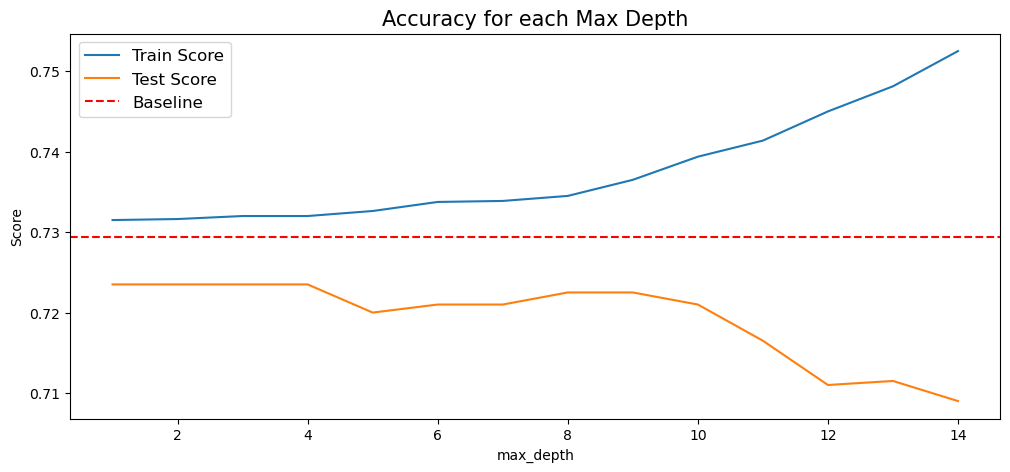

In [78]:
plt.figure(figsize=(12,5))
baseline = y.value_counts(normalize=True).sort_values(ascending=False).iloc[0]
sns.lineplot(df_tree_scores, x="max_depth", y="train_score", label="Train Score")
sns.lineplot(df_tree_scores, x="max_depth", y="test_score", label="Test Score")
plt.axhline(y = baseline, color = 'r', linestyle = '--', label="Baseline") 
plt.title("Accuracy for each Max Depth", fontsize=15)
plt.ylabel("Score")
plt.legend(fontsize=12);

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000).fit(X_train, y_train)

print("Baseline:", baseline)
print("Logistic Regression Train Accuracy:", log_reg.score(X_train, y_train))
print("Logistic Regression Test Accuracy:", log_reg.score(X_test, y_test))

Baseline: 0.7294
Logistic Regression Train Accuracy: 0.731
Logistic Regression Test Accuracy: 0.723


In [83]:
from sklearn.model_selection import GridSearchCV

rand_forest = RandomForestClassifier(random_state=42)
rand_forest.get_params()


params = {
    "n_estimators": range(50, 300, 75),
    "max_depth": range(5, 20, 5),
    "min_samples_leaf": range(1, 10, 3),
    "max_features": ['sqrt', 'log2', None]
}

model = GridSearchCV(rand_forest, param_grid=params, cv=5, n_jobs=-1, verbose=2)
model.fit(X_train, y_train)
results = pd.DataFrame(model.cv_results_)
model.best_params_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 125}

In [85]:
rand_for = model.best_estimator_
rand_for.fit(X_train, y_train)

print("Baseline:", baseline)
print("Train Accuracy:", rand_for.score(X_train, y_train))
print("Test Accuracy:", rand_for.score(X_test, y_test))

Baseline: 0.7294
Train Accuracy: 0.7365
Test Accuracy: 0.7235


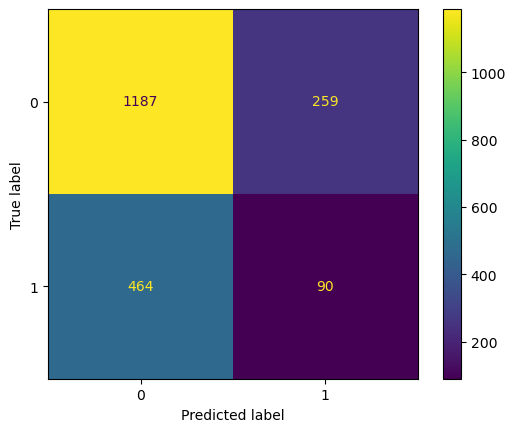

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
y_pred_prob = rand_for.predict_proba(X_test)[:, -1]
y_pred = y_pred_prob > 0.3  
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

In [92]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

y_pred_cv = cross_val_predict(model.best_estimator_, X_train, y_train, cv=10, n_jobs=-1)
print(classification_report(y_train, y_pred_cv))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84      5848
           1       0.22      0.00      0.00      2152

    accuracy                           0.73      8000
   macro avg       0.48      0.50      0.42      8000
weighted avg       0.59      0.73      0.62      8000

